<a href="https://colab.research.google.com/github/dmamur/elementsem/blob/main/elembert_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle,random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,Dense,Dropout,Input,Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import re, glob,os,sys
from collections import defaultdict
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical


In [2]:
!git clone https://github.com/dmamur/elementsem.git 

Cloning into 'elementsem'...
remote: Enumerating objects: 282, done.
remote: Total 282 (delta 0), reused 0 (delta 0), pack-reused 282
Receiving objects: 100% (282/282), 55.46 MiB | 16.39 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [27]:
class Config:
    MAX_LEN = 128
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = 128
    EMBED_DIM = 128
    NUM_HEAD = 4 # used in bert model
    FF_DIM = 128 # used in bert model
    NUM_LAYERS = 4
    MNAME = 'elembert_'
    MVER = 'V2'
    DSPATH="/content/elementsem/data/"
    PREPATH="/content/elementsem/models/pretrained/"
    PATH="/content/elementsem/models/"
config = Config()
seed=123
tf.random.set_seed(seed)
np.random.seed(seed)

In [28]:
ds = 'toxic_sr-p53'
mname=config.PATH+config.MNAME+ds+config.MVER

# Load vocabularly and types 

In [29]:
df = pd.read_csv(config.DSPATH+ds+'_ds.csv')

types = df['types'+config.MVER].apply(eval).apply(list)
labels  = to_categorical(np.asarray(df['labels']))
uniquelbls=len(np.unique(np.asarray(df['labels'])))

with open(config.PREPATH+'/el2id'+config.MVER+'.pkl', 'rb') as f:
    db = pickle.load(f)

element2id = db['el2id']
el2id = db['el2id']
config.VOCAB_SIZE = len(element2id)
print('vocabSize: ', config.VOCAB_SIZE)


vocabSize:  1856


# Convert types to integers

In [30]:
types0=[['[CLS]']+i+['[SEP]'] for i in types]
typesNumerical=[]
for i in types0:
    typesNumerical.append([element2id[j] for j in i])

x3 = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical,dtype='int32',padding= 'post',maxlen=config.MAX_LEN)

z = load_model(config.PREPATH+'/elembert_'+config.MVER+'_E_128_H_4_L_4_bert.h5',compile=False)
z.trainable = True

e = Lambda(lambda x: x[:,0],name='clsTokenEmb')(z.output)
f = Dense(uniquelbls, activation="softmax",name='out_tox')(e)

model = Model(inputs=z.input, outputs=f)

#plot_model(model, show_shapes=True, show_layer_names=True,to_file=mname+".png")

optimizer = tf.keras.optimizers.Adam(learning_rate=config.LR)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC()])

epochs=config.BATCH_SIZE
model.summary()

csv_logger = tf.keras.callbacks.CSVLogger(mname+"_log.csv", append=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(mname+".h5",verbose=2, mode='min',save_freq=1000,)

callbacks_list = [checkpoint,csv_logger]

print('dataLen: ',x3.shape,labels.shape)

p = np.random.RandomState(seed=seed).permutation(len(labels))
n = len(p)

trainidx=p[:round(len(p)*0.8)]
validx = p[int(n*0.8):int(n*0.9)]
testidx = p[int(n*0.9):]

trainlog = model.fit(x=x3[trainidx], y=labels[trainidx], 
                     validation_data = (x3[validx],labels[validx]),
                     verbose = 1,epochs = epochs, batch_size = config.BATCH_SIZE,callbacks = callbacks_list)

model.save(mname+".h5")

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 types (InputLayer)             [(None, 128)]        0           []                               
                                                                                                  
 element_embdgs (Embedding)     (None, 128, 128)     237568      ['types[0][0]']                  
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 128, 128)    0           ['element_embdgs[0][0]']         
 da)                                                                                              
                                                                                                  
 encoder_0/multiheadattention (  (None, 128, 128)    66048       ['tf.__operators__.add[0][0

# Save results

In [31]:
extractorEmb = Model(inputs=model.inputs,outputs=model.get_layer(name="clsTokenEmb").output)

preds = model.predict(x3,batch_size = config.BATCH_SIZE)

dbresults={}
dbresults['pred_emb'] = extractorEmb.predict(x3,batch_size = config.BATCH_SIZE)
dbresults['pred_cls'] = preds
dbresults['y_cls'] = labels
dbresults['formula'] = df['formula'] 
dbresults['ids'] = df['ids']  
dbresults['types'] = types
dbresults['trainidx'] = trainidx
dbresults['testidx'] = validx 
dbresults['validx'] = validx

with open(mname+'_results.pkl', 'wb') as f:
    pickle.dump(dbresults, f)

270/270 [==============================] - 3s 10ms/step


# Posrprocessing

In [32]:
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
tsne = TSNE(n_components=2, verbose=0, random_state=123)
z = tsne.fit_transform(dbresults['pred_emb'])

In [33]:
dfr = pd.DataFrame()
dfr["y"] = np.asarray(dbresults['y_cls'].argmax(axis=-1))
dfr["yp"] = np.asarray(dbresults['pred_cls'].argmax(axis=-1))
dfr["tSNE1"] = z[:,0]
dfr["tSNE2"] = z[:,1]    

binary tf-acc: 0.92468137
AUC: 0.9702149


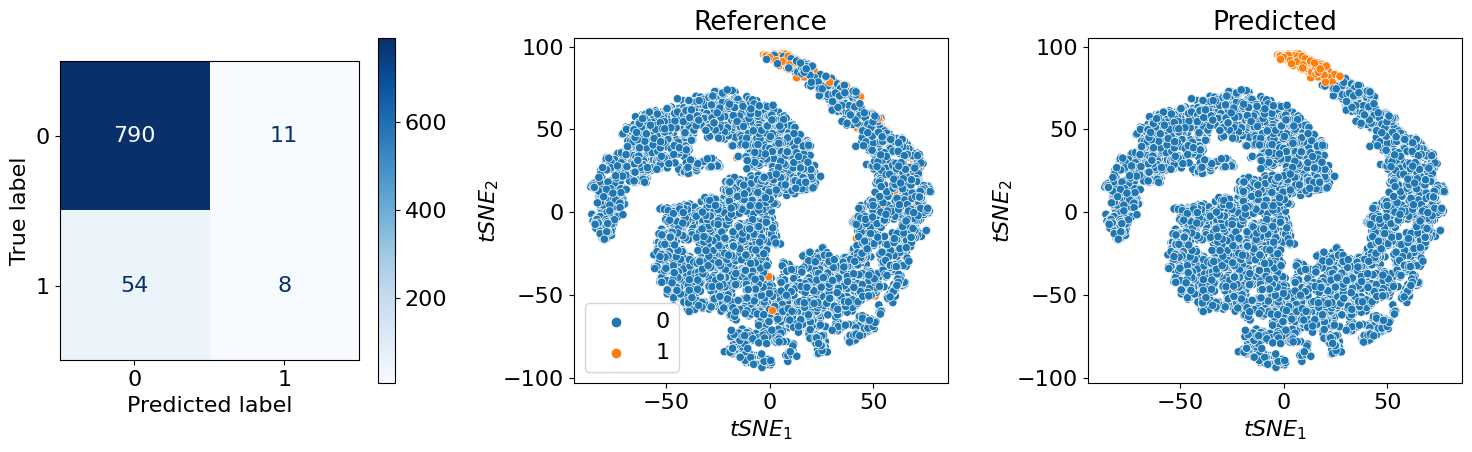

In [34]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 3, figsize=(15, 4.8))
y_pclasses = dbresults['pred_cls'][dbresults['testidx']].argmax(axis=-1)
y_classes = dbresults['y_cls'][dbresults['testidx']].argmax(axis=-1)
print('binary tf-acc:',tf.keras.metrics.binary_accuracy(y_classes, y_pclasses, threshold=0.5).numpy())
m = tf.keras.metrics.AUC()
m.update_state(dbresults['y_cls'][dbresults['testidx']], dbresults['pred_cls'][dbresults['testidx']])
print('AUC:',m.result().numpy())
confusion_matrix = metrics.confusion_matrix(y_classes, y_pclasses)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
                                            #display_labels=['False','True'])
cm_display.plot(ax=axes[0],cmap=plt.cm.Blues)

sns.scatterplot(ax=axes[1],x="tSNE1", y="tSNE2", hue=dfr.y.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[1].set_xlabel('$tSNE_1$')
axes[1].set_ylabel('$tSNE_2$',labelpad=1)
axes[1].set_title('Reference')
#axes[1].legend('',frameon=False)
sns.scatterplot(ax=axes[2],x="tSNE1", y="tSNE2", hue=dfr.yp.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[2].set_title('Predicted')
axes[2].set_xlabel('$tSNE_1$')
axes[2].set_ylabel('$tSNE_2$',labelpad=1)
axes[2].legend('',frameon=False)
fig.tight_layout()
plt.show()
#plt.savefig(mname+'_tsnePaper.jpg',format='jpg',dpi=800,bbox_inches = "tight")